# Import Necessary Packages

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import gc

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load DATA

In [2]:
# read DATA
data = pd.read_csv("C:/Users/bened/Documents/UNIVERSITY/SchoenStats/PyTorch Working Directory/Undergrad Stats Project/wave_data_gen_ugstprj_rot.csv")
data.info()

# random sample from dataset
# DO NOT RUN BLOCK if testing under same data;
# ...or else dataset will be lost and new data sample
X = data.sample(10000).reset_index(drop=True)
X_train = torch.tensor(X.values)
X = data.sample(2000).reset_index(drop=True)
X_test = torch.tensor(X.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99112 entries, 0 to 99111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       99112 non-null  float64
 1   y       99112 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


Text(0.5, 1.0, 'Training Distribution')

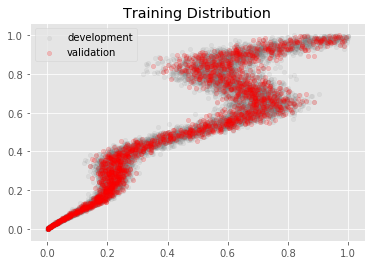

In [3]:
plt.scatter(X_train[:,0], X_train[:,1], alpha=0.1, s=20, label='development', color='grey')
plt.scatter(X_test[:,0], X_test[:,1], alpha=0.2, s=20, label='validation', color='red')
plt.legend(loc='upper left')
plt.title("Training Distribution")

# Define MODEL

In [64]:
# defining the MODEL
# define the neural network class
class LinRegr(nn.Module):

    def __init__(self, in_features, n1_hidden, out_features):
        super(LinRegr, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features, n1_hidden),
            nn.Tanh(),
            nn.Linear(n1_hidden, n1_hidden),
            nn.Tanh(),
            nn.Linear(n1_hidden, n1_hidden),
            nn.Tanh(),
            nn.Linear(n1_hidden, n1_hidden),
            nn.Tanh(),
            nn.Linear(n1_hidden, n1_hidden),
            nn.Tanh(),
            nn.Linear(n1_hidden, out_features))
    
    def forward(self, x):
        out = self.layer1(x)
        return out

net = LinRegr(in_features=1, n1_hidden=25, out_features=1)
optimizer = torch.optim.Adam(net.parameters())
loss = nn.MSELoss()

In [65]:
# 'garbage collect' for extra RAM space
gc.collect()

4925

# Training Step

In [66]:
# TRAINING the model
# epoch time
num_epoch = 300
batch_size = 64

net=net.double()
loss_list = []

for epoch in tqdm(range(num_epoch)):
    permu = torch.randperm(X_train.shape[0])
    
    for i in range(0, X_train.shape[0], batch_size):
        indices = permu[i:i+batch_size]
        batch_x, batch_y = X_train[indices,0], X_train[indices,1]
        t = net.forward(batch_x.unsqueeze(1))
        optimizer.zero_grad()
        l = loss(t, batch_y.unsqueeze(1))
        l.backward()
        optimizer.step()

    if epoch % 1 == 0:
        loss_list.append(l.detach())

100%|██████████| 300/300 [02:31<00:00,  1.98it/s]


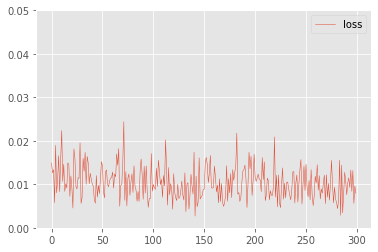

In [67]:
# Epochs vs Loss
plt.plot(range(num_epoch), np.array(loss_list), label='loss', linewidth=0.5)
plt.ylim((0, 0.05))
plt.legend()

# Generating Samples

In [68]:
# GENERATE samples from model
num_samples = 2000
res = torch.empty(0)
for i in range(num_samples):
    k = net(X_test[i:i+1,0]).detach()
    res = torch.cat((res, k), 0)

In [69]:
# rearrange results
x0 = X_test[:,0]
t_true = X_test[:,1]
t_pred = res
results = pd.DataFrame(np.array(torch.stack((x0, t_true, t_pred))).T, columns=('x', 't', 't_pred'))

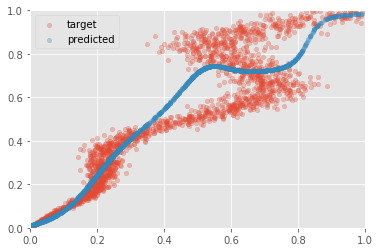

In [70]:
# plot of predicted values
plt.scatter(results['x'], results['t'], alpha=0.3, s=20, label='target')
plt.scatter(results['x'], results['t_pred'], alpha=0.3, s=20, label='predicted')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='upper left')

# Root Mean Squared (RMS)

In [71]:
diff = (t_pred - t_true)
L2_diff = np.square(diff)

In [72]:
avg_diff = sum(np.array(L2_diff)) / num_samples
RMS = np.sqrt(avg_diff)
print("RMS: {}".format(np.around(RMS, decimals=6)))

RMS: 0.105316


(0, 0.2)

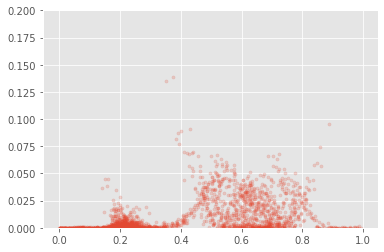

In [73]:
plt.scatter(x0, L2_diff, s=10, alpha=0.2)
plt.ylim((0,0.2))

# Log-likelihood Test

In [74]:
# log likelihood function for toy dataset
def toy_data_log_prob_adjust_x(t, x, var=0.09):
    lp_list =[]
    for i in tqdm(range(len(t))):
        sigma_sqr = float(0.09 * (x[i] ** 2))
        f = torch.distributions.normal.Normal(0, sigma_sqr)
        lp_list.append(f.log_prob(t[i]))
    return lp_list

In [75]:
# calculation of loglikelihood
LLp = sum(toy_data_log_prob_adjust_x(diff, x0))

print("Log-likelihood of predicted targets: {}".format(LLp))

100%|██████████| 2000/2000 [00:00<00:00, 3395.35it/s]

Log-likelihood of predicted targets: -182270200905.8944


# Neural Network Model Summary

(-0.5, 0.5)

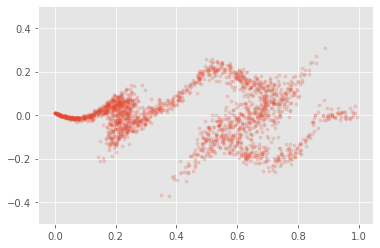

In [76]:
# difference plot
plt.scatter(x0, diff, s=10, alpha=0.2)
plt.ylim((-0.5,0.5))

In [77]:
# summary of model parameters
for name, param in net.named_parameters():
    print("{}\n{}\n".format(name, param))

layer1.0.weight
Parameter containing:
tensor([[-1.3157e+00],
        [-1.2718e-03],
        [-2.0256e-01],
        [-1.0616e+00],
        [-8.7587e-01],
        [-6.7833e-01],
        [-6.1300e-01],
        [-2.1373e-01],
        [ 1.0923e+00],
        [ 2.3021e-03],
        [-6.9848e-01],
        [ 6.2388e-01],
        [-1.9601e-01],
        [-6.5964e-01],
        [-6.3716e-01],
        [-9.0947e-01],
        [ 2.5838e-01],
        [-8.9719e-01],
        [-5.5734e-01],
        [ 5.7806e-01],
        [ 8.0435e-01],
        [-1.0497e-01],
        [ 6.5054e-01],
        [ 1.4286e+00],
        [ 9.4469e-01]], dtype=torch.float64, requires_grad=True)

layer1.0.bias
Parameter containing:
tensor([ 0.1050,  0.0010,  0.0086,  0.4122,  0.5902,  0.0428,  0.5105,  0.1029,
        -0.9862, -0.0024, -0.6230, -0.6003,  0.2850,  0.3270,  0.3879,  0.7571,
         0.2497,  0.8344,  0.6295, -0.4289, -0.1719,  0.1242,  0.3825,  0.1035,
        -0.7091], dtype=torch.float64, requires_grad=True)

layer1.2

In [78]:
#acc = sum(np.around(np.array(t_pred), decimals=2) == np.around(np.array(t_true), decimals=2)) * 100 /num_samples
#print("Model Accuracy: {}%".format(acc))